In [226]:
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from pathlib import Path
import random

In [227]:
main_directory = Path("./archive/PetImages")
cat_directory = main_directory / 'Cat'
dog_directory = main_directory / 'Dog'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter
    transforms.ToTensor(),
])


dataset = datasets.ImageFolder(main_directory, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [228]:
class_to_idx = dataset.class_to_idx
dataset.classes

['Cat', 'Dog']

In [229]:
def random_image():
    img, label = dataset[random.randint(0, len(dataset))]
    return img, label

img, label = random_image()

In [230]:
img.shape

torch.Size([3, 128, 128])

In [231]:
conv1 = nn.Conv2d(3, 8, 3) 
conv1(img).shape
maxpool2d = nn.MaxPool2d(2, 2)
maxpool2d(conv1(img)).shape
conv2 = nn.Conv2d(8, 16, 4)
conv2(maxpool2d(conv1(img))).shape
flatten = nn.Flatten()
flatten(conv2(maxpool2d(conv1(img)))).shape

#fc1 = nn.Linear(3600, 16)

#fc1(flatten(conv2(maxpool2d(conv1(img))))).shape

torch.Size([16, 3600])

In [232]:
import torch
import torch.nn as nn
import torchvision.models as models

class CatOrDog(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pretrained ResNet model
        self.model = models.resnet18(pretrained=True)  # You can choose other models like resnet50, vgg16, etc.

        # Modify the final fully connected layer for binary classification
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 2)  # Change output layer to have 2 outputs (for cat and dog)

    def forward(self, x):
        return self.model(x)  # Forward pass through the ResNet model

# Instantiate the model
model = CatOrDog()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model architecture
print(model)


CatOrDog(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [233]:
model = CatOrDog()

In [234]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [235]:
from PIL import Image
import os

def check_and_delete_bad_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f'Deleting bad file: {file_path}')
                os.remove(file_path)  # Delete the bad file

# Specify your directory
check_and_delete_bad_images('./archive/PetImages')  # Check and clean your image folder


In [236]:
i = 0
correct = 0  # Variable to count correct predictions
total = 0  # Variable to count total samples

for epoch in range(3):
    for images, labels in dataloader:
        i += 1
        optimizer.zero_grad()  

        outputs = model(images)
        loss = loss_fn(outputs, labels)  

        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        total += labels.size(0)  # Increment total samples
        correct += (predicted == labels).sum().item()  # Increment correct predictions

        # Print every 100 images
        if i % 100 == 0:
            accuracy = 100 * correct / total  # Calculate accuracy
            print(f"Image: {i}/{len(dataloader)} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.2f}%")

    # Reset counts for the next epoch
    correct = 0
    total = 0

    # Print loss for the epoch
    print(f"Epoch: {epoch} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.2f}%")


Image: 100/782 | Loss: 0.2619 | Accuracy: 84.41%
Image: 200/782 | Loss: 0.0637 | Accuracy: 87.70%
Image: 300/782 | Loss: 0.2353 | Accuracy: 88.83%
Image: 400/782 | Loss: 0.0779 | Accuracy: 89.73%
Image: 500/782 | Loss: 0.1015 | Accuracy: 90.16%
Image: 600/782 | Loss: 0.0784 | Accuracy: 90.44%
Image: 700/782 | Loss: 0.0982 | Accuracy: 90.74%
Epoch: 0 | Loss: 0.0226 | Accuracy: 90.74%
Image: 800/782 | Loss: 0.0511 | Accuracy: 94.97%
Image: 900/782 | Loss: 0.4153 | Accuracy: 93.59%
Image: 1000/782 | Loss: 0.1573 | Accuracy: 93.61%
Image: 1100/782 | Loss: 0.2103 | Accuracy: 93.85%
Image: 1200/782 | Loss: 0.0987 | Accuracy: 93.79%
Image: 1300/782 | Loss: 0.1352 | Accuracy: 93.97%
Image: 1400/782 | Loss: 0.0505 | Accuracy: 93.97%
Image: 1500/782 | Loss: 0.2022 | Accuracy: 94.00%
Epoch: 1 | Loss: 0.0357 | Accuracy: 94.00%
Image: 1600/782 | Loss: 0.1136 | Accuracy: 96.01%
Image: 1700/782 | Loss: 0.0742 | Accuracy: 95.66%
Image: 1800/782 | Loss: 0.0646 | Accuracy: 95.35%
Image: 1900/782 | Loss:

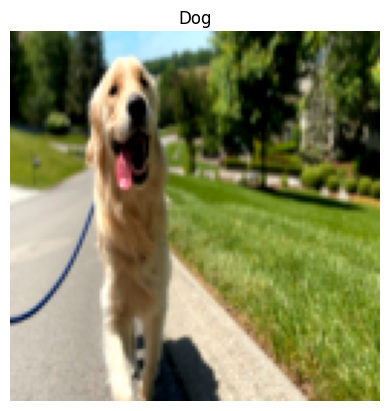

In [253]:
model.eval()
img = Image.open('./dogtest.png')
if img.mode == 'RGBA':
    img = img.convert('RGB')
img = transform(img)
with torch.no_grad():
    pred = model(img.unsqueeze(0)).argmax(dim=1)
    pred_word = dataset.classes[pred[0]]
    plt.imshow(img.permute(1,2,0))
    plt.title(pred_word)
    plt.axis('off')

In [238]:
from collections import Counter

# Get the class distribution
class_counts = Counter(label for _, label in dataset.samples)
print(class_counts)  # Print counts for each class

Counter({0: 12500, 1: 12500})


In [254]:
torch.save(model, './dogorcat.pth')